In [2]:
import numpy as np
import pandas as pd
%pylab inline
from pylab import rcParams
from pandas import DataFrame
#import seaborn; seaborn.set()
rcParams['figure.figsize'] = 16,8
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import ward_tree
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from fastdtw import fastdtw
from operator import itemgetter
from scipy.stats import itemfreq
from scipy.cluster.hierarchy import dendrogram, linkage


Populating the interactive namespace from numpy and matplotlib


## Dataset: IBM stock values from 1962 to 2018

In [3]:
series = pd.Series.from_csv('ibm_daily_1962-2018.csv', sep='\t',header=0)

In [4]:
series = series["1962-01-02":"2017-12-29"] # Rimuovo il 2018

In [5]:
groups = series.groupby(pd.Grouper(freq='A'))
years = []
yearly_series = []
yearly_list = []
for name, group in groups:
    years.append(name.year) # Lista contenente gli anni
    yearly_series.append(pd.Series(group)) # Lista contenente serie pandas per ogni anno
    yearly_list.append(list(group.values)) # Lista contenente liste per ogni anno

### Heatmap dati normalizzati e smooth (per confronto con dati clusterizzati)

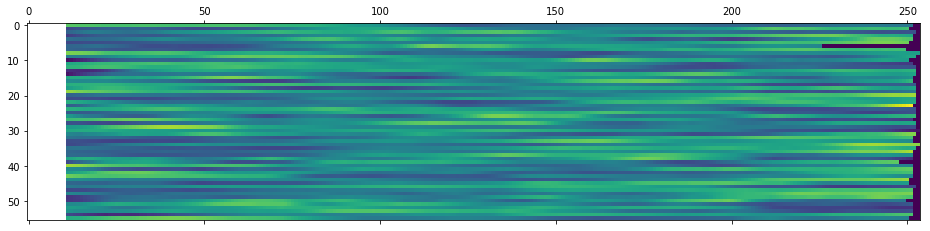

In [13]:
groups = series.groupby(pd.Grouper(freq='A'))
mm = DataFrame()
for name, group in groups:
    norm_values = (group.values - mean(group.values)) / std(group.values)
    norm_series = pd.Series(norm_values) #trasformo in serie per calcolare la rolling mean
    shift_series = norm_series.rolling(window=12).mean()
    norm_array = np.array(shift_series)
    # Padding performed to have series of same length -- important only for plotting the matrix
    pad_values = np.pad(norm_array,(0,254-len(norm_array)),'constant',constant_values=-3)
    mm["%s" % (name.year)] = pad_values
matshow(mm.T, interpolation=None, aspect='auto')

In [14]:
# Serie Normalizzate + Smoothing
groups = series.groupby(pd.Grouper(freq='A'))
yearly_list_smooth = []
for name, group in groups:
    group_values = list(group.values)
    scaling_values = (group_values - mean(group_values))/std(group_values)
    scaling_series = pd.Series(scaling_values) #trasformo in serie per calcolare la rolling mean
    shift_series = scaling_series.rolling(window=12).mean()
    yearly_list_smooth.append(list(shift_series))

In [15]:
yearly_series_smooth = []
for i in range(len(yearly_list_smooth)):
    yearly_series_smooth.append(pd.Series(yearly_list_smooth[i]))
    yearly_series_smooth[i] = pd.Series.dropna(yearly_series_smooth[i])

## Clustering con CDM

In [105]:
# Importo le matrici come dataframe

dd1_smooth_df = pd.read_csv("dd1_smooth_cdm.csv", header = None)
dd2_smooth_df = pd.read_csv("dd2_smooth_cdm.csv", header = None)

In [106]:
# Converto le i dataframe in liste di liste
dd1 = dd1_smooth_df.values.tolist()
dd2 = dd2_smooth_df.values.tolist()

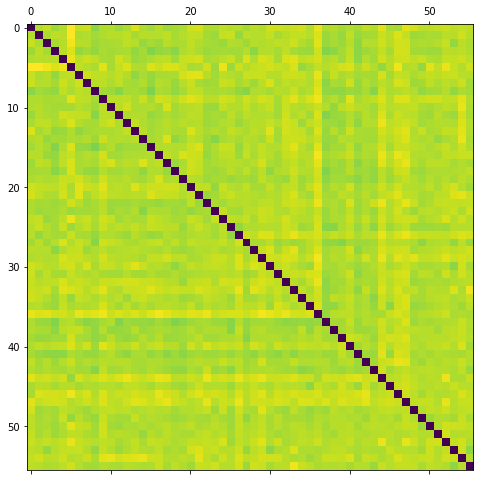

In [107]:
matshow(dd2, interpolation=None, aspect='auto')

### DBScan

#### Scelta eps

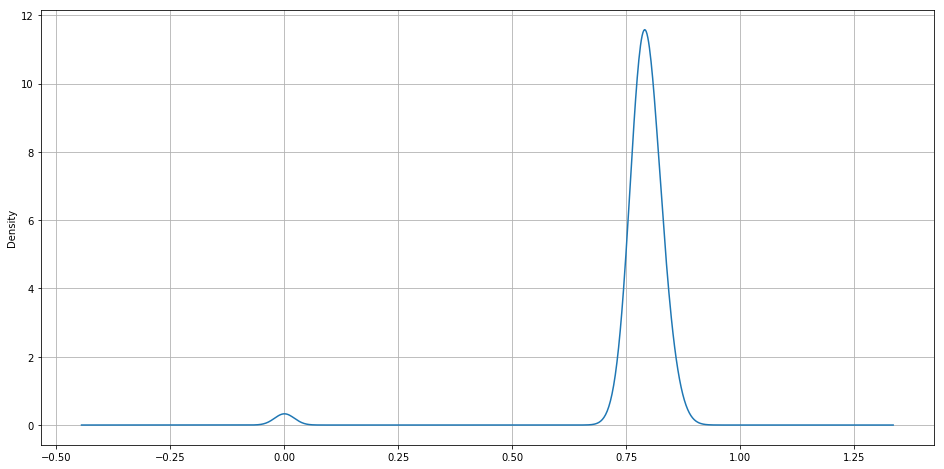

In [108]:
from pandas import Series
Series(reshape(dd2,(1,56*56))[0]).plot(kind='kde')
pyplot.grid(True)
#plot(sort(reshape(dd2,(1,56*56))[0]))
#plot([0,2400],[56,56],'r--')

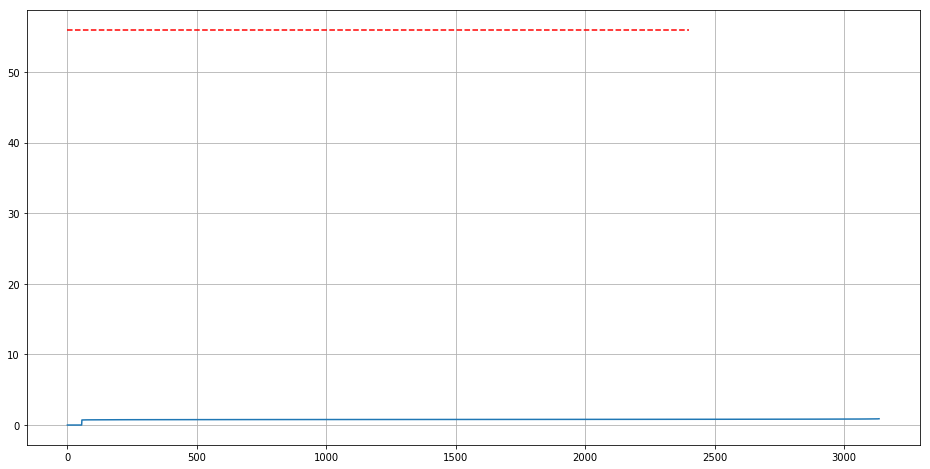

In [109]:
pyplot.grid(True)
plot(sort(reshape(dd2,(1,56*56))[0]))
plot([0,2400],[56,56],'r--')

Text(0.5,1,'N. clusters (orange) and noise size (blue) vs. eps')

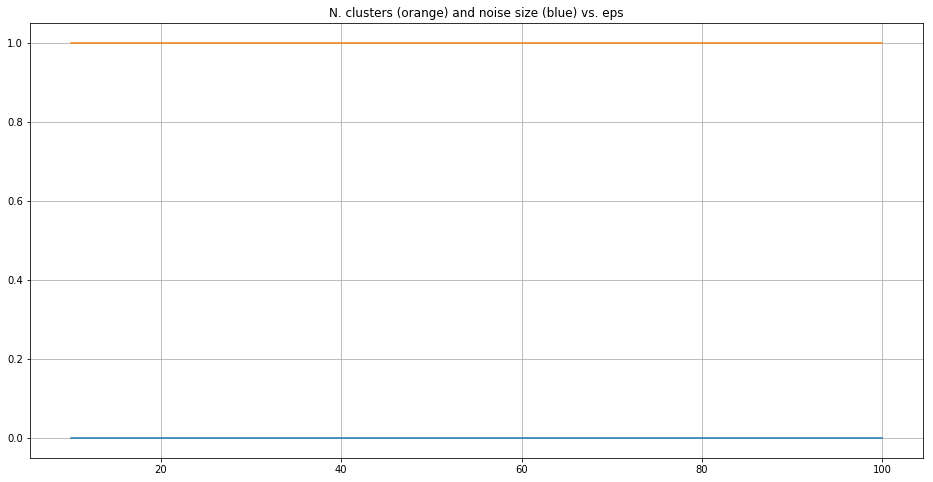

In [110]:
eps_list = linspace(10.0,100.0,num=200)
#eps_list = linspace(0.78,0.8,num=200)
noise_list = array([])
n_clusters_list = array([])
for myeps in eps_list:
    db = DBSCAN(myeps, min_samples=2, metric='precomputed').fit(dd2)
    noise_list = append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    n_clusters_list = append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
plot(eps_list, noise_list/56)
plot(eps_list, n_clusters_list)
pyplot.grid(True)
pyplot.title("N. clusters (orange) and noise size (blue) vs. eps")
#plot([0.8,0.8],[0,5],'r-')

#### Clustering

In [111]:
from scipy.stats import itemfreq

eps = 0.001

db = DBSCAN(eps, min_samples=2, metric='precomputed').fit(dd2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Number of clusters found: %d' % n_clusters_)
print (itemfreq(db.labels_))

year_index= pd.Index(years) # Converto la lista degli anni in un pandas index array!!!
cluster_sets = [ (l_,year_index[db.labels_ == l_]) for l_ in set(db.labels_) ]
for pp in cluster_sets:
    print (pp[0], "\t--> ", list(pp[1]))

Number of clusters found: 0
[[-1 56]]
-1 	-->  [1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


#### Plot

Stress value:  151.457879832


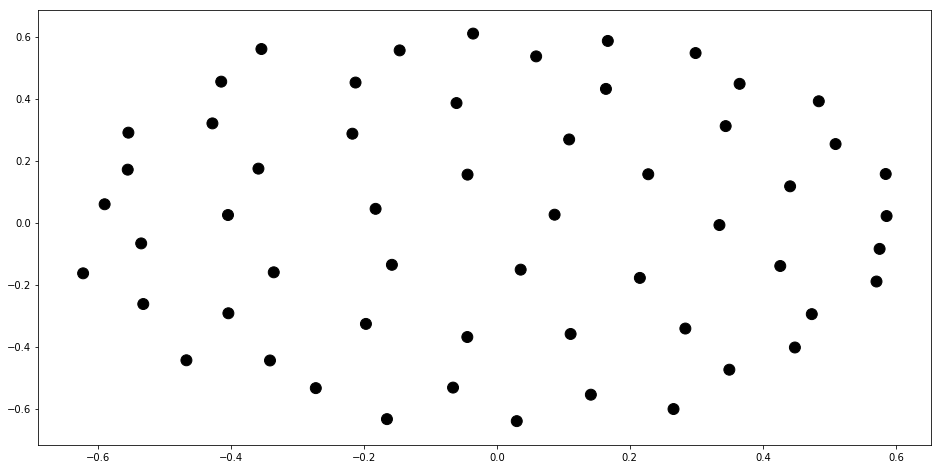

In [112]:
from sklearn import manifold
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dd2)
print ("Stress value: ", pos.stress_)

# Assign colors based on clusters
db = DBSCAN(eps, min_samples=2, metric='precomputed').fit(dd2)

'''
# Genera tutti i colori possibili (se non ci sono abbastanza colori per i cluster dà errore)
cols=[]
for name, hex in matplotlib.colors.cnames.items():
    cols.append(name)#print(name, hex)
'''
cols = ['black', 'green', 'red', 'gray', 'darkgreen', 'gold', 'orange', 'blue', 'pink', 'purple']  

cc = [ cols[l+1] for l in db.labels_]
scatter(pos.embedding_.T[0], pos.embedding_.T[1], color=cc, s=120)

### KMeans

#### Scelta di k

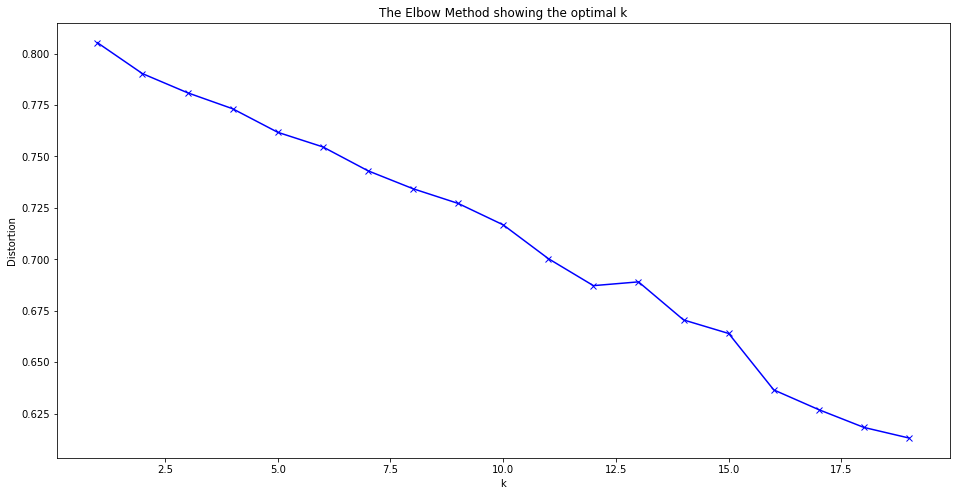

In [113]:
from scipy.spatial.distance import cdist
# k means determine k
distortions = []
dd2 = np.array(dd2)
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(dd2)
    kmeanModel.fit(dd2)
    distortions.append(sum(np.min(cdist(dd2, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / dd2.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Clustering

In [114]:
db = KMeans(n_clusters=10, random_state=0).fit(dd2)

n_clusters_ = len(set(db.labels_))

print('Number of clusters found: %d' % n_clusters_)
print (itemfreq(db.labels_))

year_index= pd.Index(years) # Converto la lista degli anni in un pandas index array!!!
cluster_sets = [ (l_,year_index[db.labels_ == l_]) for l_ in set(db.labels_) ]
for pp in cluster_sets:
    print (pp[0], "\t--> ", list(pp[1]))

Number of clusters found: 10
[[0 4]
 [1 3]
 [2 8]
 [3 5]
 [4 6]
 [5 5]
 [6 9]
 [7 2]
 [8 7]
 [9 7]]
0 	-->  [1967, 1998, 2006, 2016]
1 	-->  [1994, 2010, 2014]
2 	-->  [1965, 1975, 1978, 1980, 1984, 1990, 1999, 2012]
3 	-->  [1968, 1969, 1971, 1977, 1988]
4 	-->  [1981, 1986, 1996, 2002, 2007, 2008]
5 	-->  [1964, 1992, 2009, 2015, 2017]
6 	-->  [1972, 1976, 1983, 1987, 1995, 1997, 2000, 2004, 2013]
7 	-->  [1982, 1991]
8 	-->  [1963, 1966, 1974, 1979, 1985, 1993, 2003]
9 	-->  [1962, 1970, 1973, 1989, 2001, 2005, 2011]


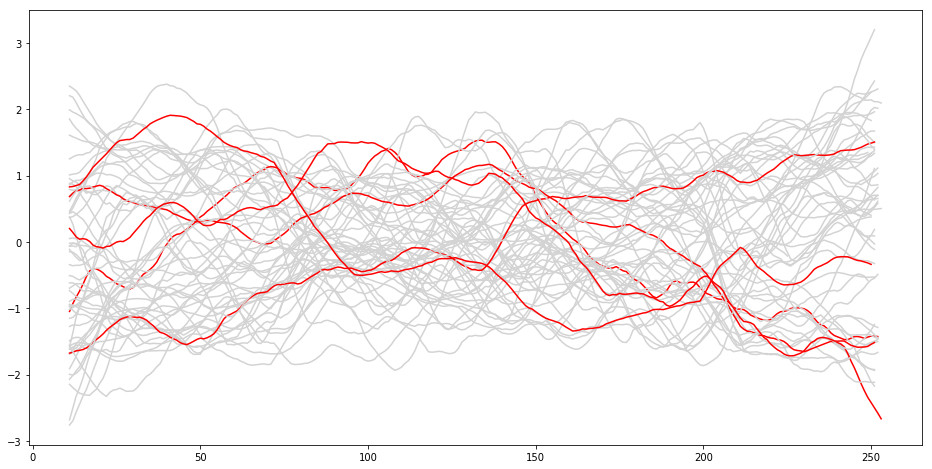

In [123]:
for i in range(len(db.labels_)):
    plot(yearly_series_smooth[i],'r-' if db.labels_[i]==5 else 'lightgray')

In [124]:
# Creo una lista con all'interno i cluster e converto gli anni in indici per plottarli
clusters_list = []
for i in range(len(cluster_sets)):
    clusters_list.append(list(cluster_sets[i][1]))
for i in range(len(clusters_list)):
    for j in range(len(clusters_list[i])):
        clusters_list[i][j] = clusters_list[i][j]%1962

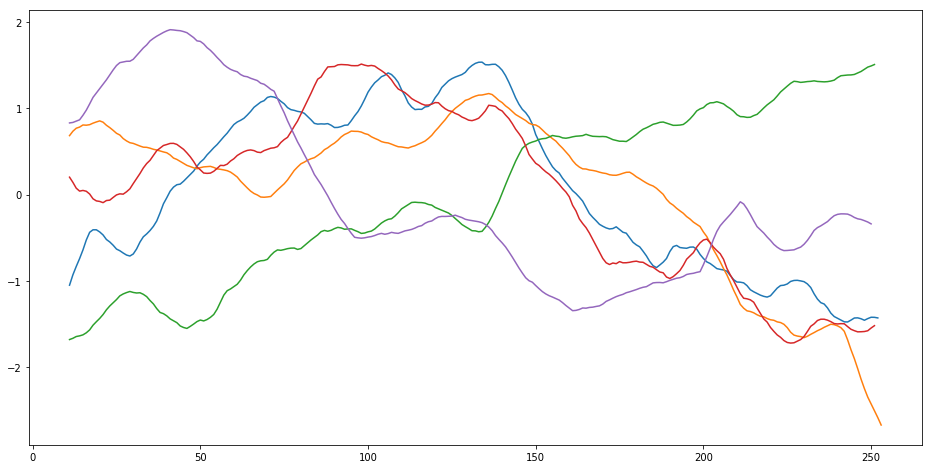

In [125]:
cluster_n = 5
for i in range(len(clusters_list[cluster_n])):
    plt.plot(yearly_list_smooth[clusters_list[cluster_n][i]])

#### Confronto Heatmap pre/post clustering

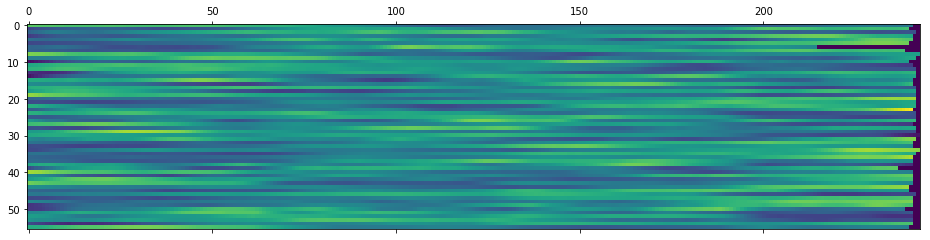

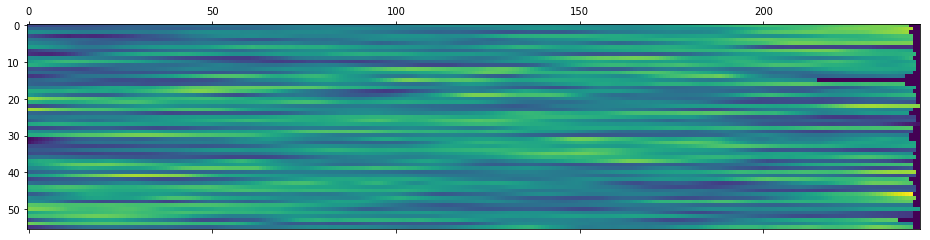

In [126]:
groups = series.groupby(pd.Grouper(freq='A'))
mm = DataFrame()
for name, group in groups:
    scaling_values = (group.values - mean(group.values))/std(group.values)
    scaling_series = pd.Series(scaling_values)
    shift_values = scaling_series.rolling(window=12).mean()
    shift_values=shift_values.dropna()
    shift_values = np.array(shift_values)
    pad_values = np.pad(shift_values,(0,254-len(group.values)),'constant',constant_values=-3)
    mm["%s" % (name.year)] = pad_values
    
mm_sort=sorted(zip(array(mm.T),db.labels_),key=itemgetter(1))
mm_sort2=[el[0] for el in mm_sort]
matshow(mm.T, interpolation=None, aspect='auto')
matshow(mm_sort2, interpolation=None, aspect='auto')

### Hierarchical

In [127]:
h_clustering = linkage(np.array(dd2), 'ward')

/Users/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


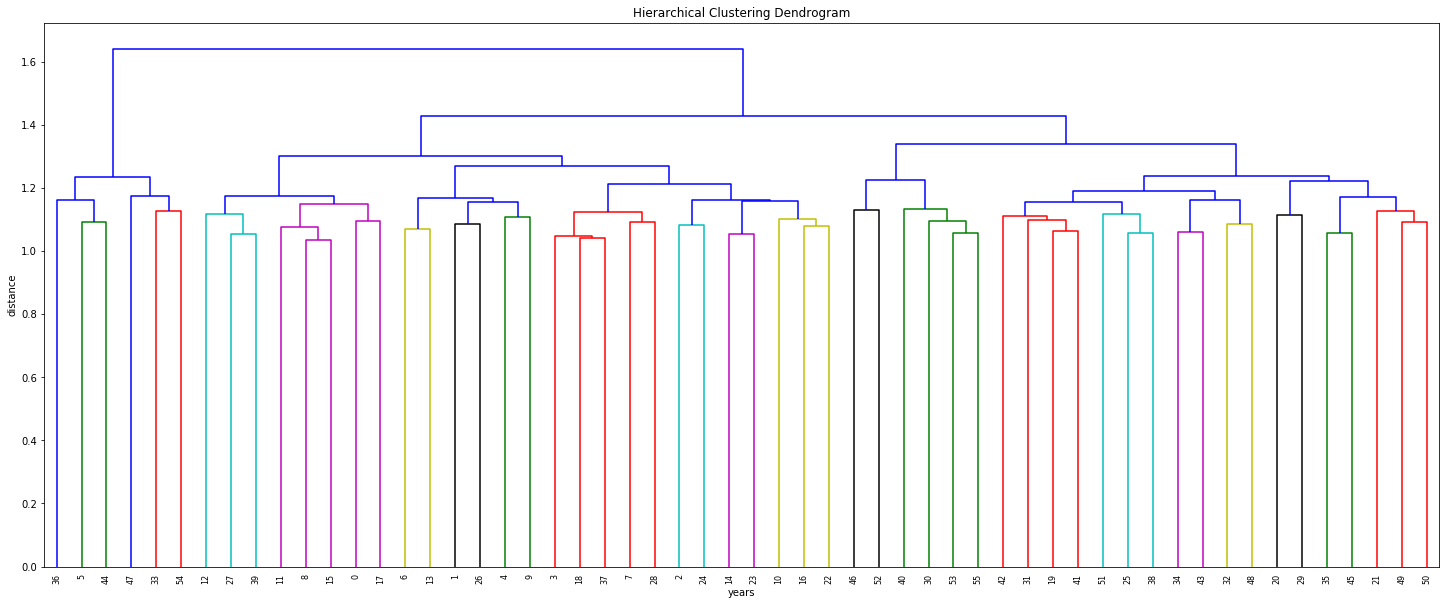

In [128]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('years')
plt.ylabel('distance')
dendrogram(
    h_clustering,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

#### Silhouette score

/Users/francesco/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


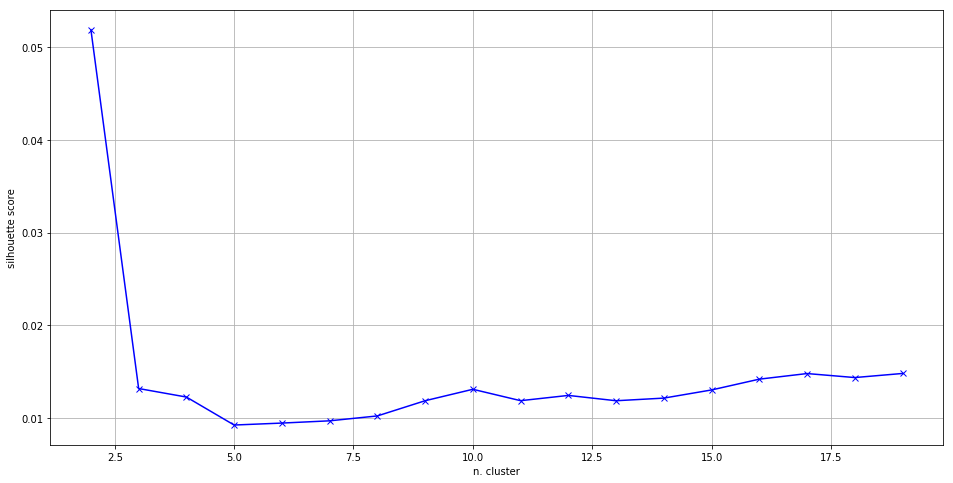

In [129]:
k = list(range(2,20))
silhouettes = []
for i in k:
    db = AgglomerativeClustering(n_clusters=i, linkage = 'ward').fit(dd2)
    silhouettes.append(silhouette_score(dd2, db.labels_))
# Plot silhouette scores
plt.grid()
plt.plot(k, silhouettes, 'bx-')
plt.xlabel('n. cluster')
plt.ylabel('silhouette score')
plt.show()

In [130]:
db = AgglomerativeClustering(n_clusters=10, linkage = 'ward').fit(dd2)
sil = silhouette_score(dd2, db.labels_)
# Number of clusters in labels, ignoring noise if present.

n_clusters_ = len(set(db.labels_))

print('Number of clusters found: %d' % n_clusters_)
print (itemfreq(db.labels_))

year_index= pd.Index(years) # Converto la lista degli anni in un pandas index array!!!
cluster_sets = [ (l_,year_index[db.labels_ == l_]) for l_ in set(db.labels_) ]
for pp in cluster_sets:
    print (pp[0], "\t--> ", list(pp[1]))

Number of clusters found: 10
[[ 0 12]
 [ 1  8]
 [ 2 11]
 [ 3  3]
 [ 4  4]
 [ 5  6]
 [ 6  5]
 [ 7  3]
 [ 8  2]
 [ 9  2]]
0 	-->  [1964, 1965, 1969, 1972, 1976, 1978, 1980, 1984, 1985, 1986, 1990, 1999]
1 	-->  [1962, 1970, 1973, 1974, 1977, 1979, 1989, 2001]
2 	-->  [1981, 1987, 1993, 1994, 1996, 2000, 2003, 2004, 2005, 2010, 2013]
3 	-->  [1995, 2009, 2016]
4 	-->  [1992, 2002, 2015, 2017]
5 	-->  [1963, 1966, 1968, 1971, 1975, 1988]
6 	-->  [1983, 1997, 2007, 2011, 2012]
7 	-->  [1967, 1998, 2006]
8 	-->  [2008, 2014]
9 	-->  [1982, 1991]


/Users/francesco/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


#### Plot

In [131]:
# Creo una lista con all'interno i cluster e converto gli anni in indici per plottarli
clusters_list = []
for i in range(len(cluster_sets)):
    clusters_list.append(list(cluster_sets[i][1]))
for i in range(len(clusters_list)):
    for j in range(len(clusters_list[i])):
        clusters_list[i][j] = clusters_list[i][j]%1962

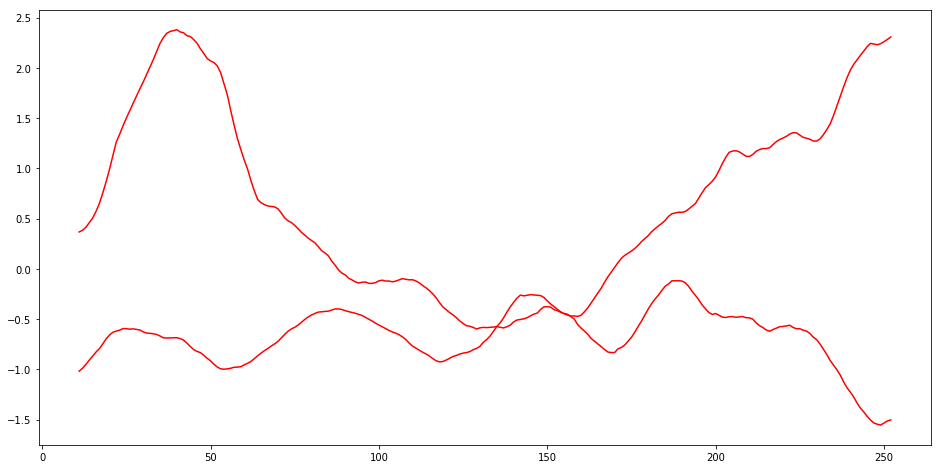

In [142]:
cluster_n = 9
for i in range(len(clusters_list[cluster_n])):
    plt.plot(yearly_list_smooth[clusters_list[cluster_n][i]], color ="red")

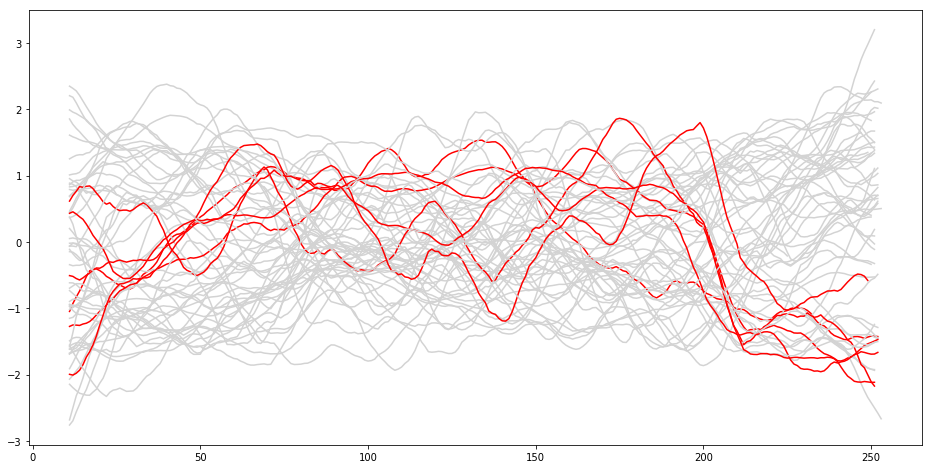

In [83]:
for i in range(len(db.labels_)):
    plot(yearly_series_smooth[i],'r-' if db.labels_[i]==4 else 'lightgray')

#### Confronto Heatmap pre/post clustering

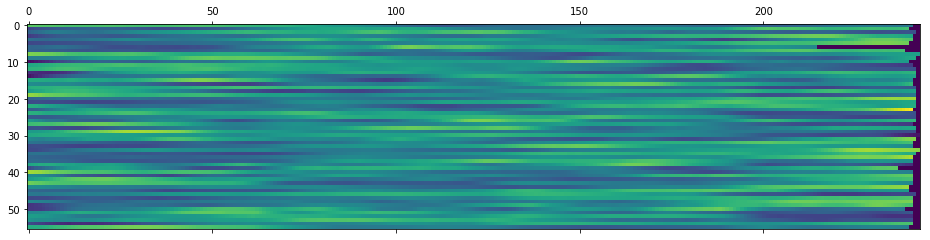

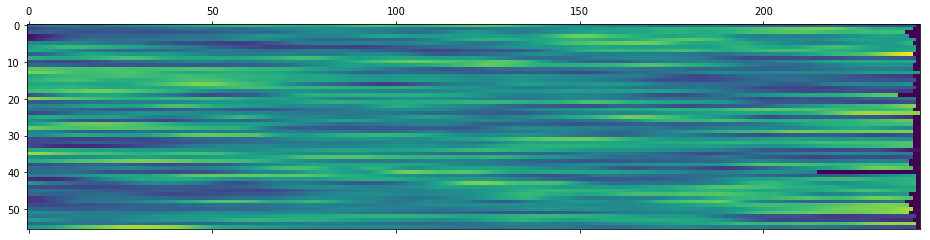

In [143]:
groups = series.groupby(pd.Grouper(freq='A'))
mm = DataFrame()
for name, group in groups:
    scaling_values = (group.values - mean(group.values))/std(group.values)
    scaling_series = pd.Series(scaling_values)
    shift_values = scaling_series.rolling(window=12).mean()
    shift_values=shift_values.dropna()
    shift_values = np.array(shift_values)
    pad_values = np.pad(shift_values,(0,254-len(group.values)),'constant',constant_values=-3)
    mm["%s" % (name.year)] = pad_values
    
mm_sort=sorted(zip(array(mm.T),db.labels_),key=itemgetter(1))
mm_sort2=[el[0] for el in mm_sort]
matshow(mm.T, interpolation=None, aspect='auto')
matshow(mm_sort2, interpolation=None, aspect='auto')